In [1]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# A Primer on Bayesian Methods for Multilevel Modeling

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

We will motivate this topic using an environmental epidemiology example.

### Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](http://www.fix-your-radon.com/images/how_radon_enters.jpg)

The EPA did a study of radon levels in 80,000 houses. Two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota.

The hierarchy in this example is households within county. 

### Data organization

First, we import the data from a local file, and extract Minnesota's data.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

# Import radon data
srrs2 = pd.read_csv('../data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN']

Next, obtain the county-level predictor, uranium, by combining two variables.

In [3]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv('../data/cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

/Users/fonnescj/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Use the `merge` method to combine home- and county-level information in a single DataFrame.

In [4]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [5]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


We also need a lookup table (`dict`) for each unique county, for indexing.

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

Finally, create local copies of variables.

In [7]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

Distribution of radon levels in MN (log scale):

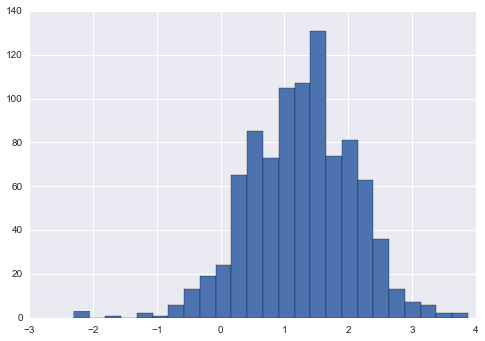

In [8]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

Here are the point estimates of the slope and intercept for the complete pooling model:

In [9]:
from pymc import Normal, Gamma, Uniform, Lambda, MCMC, Matplot

floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

def pooled_model():
    
    beta = Normal('beta', 0, 1e-5, value=[0,0])
    tau = Gamma('tau', 1, 0.1, value=1)
    
    theta = Lambda('theta', lambda b=beta: b[0] + b[1]*floor)
    
    y = Normal('y', theta, tau, value=log_radon, observed=True)
    
    return(locals())

In [10]:
M_pooled = MCMC(pooled_model())
M_pooled.sample(10000, 5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.8 sec

In [11]:
b0, m0 = M_pooled.beta.trace().T.mean(1)

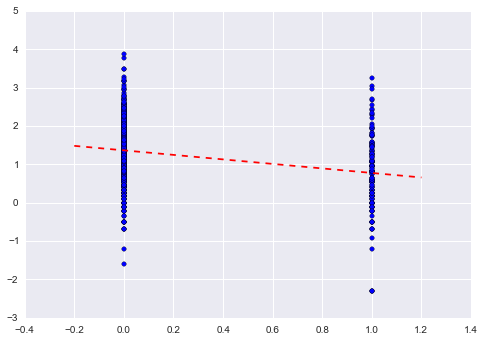

In [12]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--')

Estimates of county radon levels for the unpooled model:

In [13]:
def unpooled_model():
    
    beta0 = Normal('beta0', 0, 1e-5, value=[0]*counties)
    beta1 = Normal('beta1', 0, 1e-5, value=0)
    tau = Gamma('tau', 1, 0.1, value=1)
    
    theta = Lambda('theta', lambda b0=beta0, b1=beta1: b0[county] + b1*floor)
    
    y = Normal('y', theta, tau, value=log_radon, observed=True)
    
    return(locals())

In [14]:
M_unpooled = MCMC(unpooled_model())
M_unpooled.sample(20000, 10000)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.0 sec

In [15]:
unpooled_estimates = pd.Series(M_unpooled.beta0.stats()['mean'], index=mn_counties)
unpooled_se = pd.Series(M_unpooled.beta0.stats()['standard deviation'], index=mn_counties)

We can plot the ordered estimates to identify counties with high radon levels:

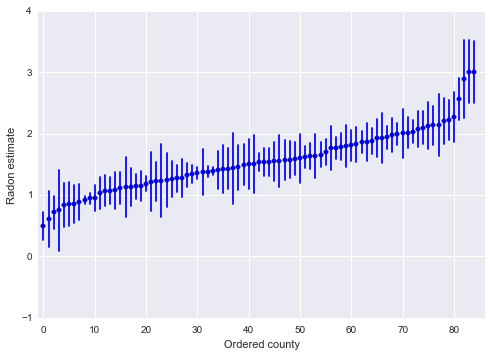

In [16]:
order = unpooled_estimates.order().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

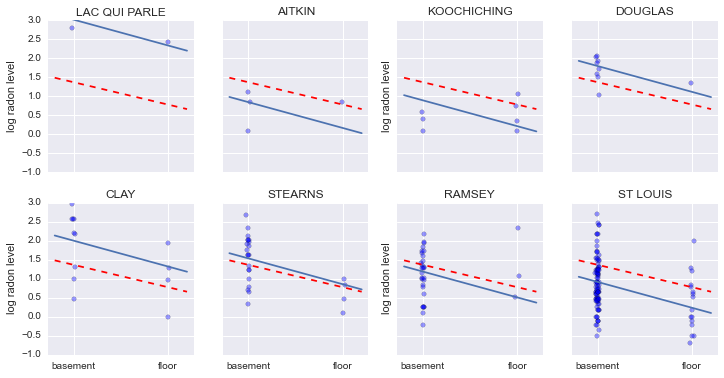

In [17]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = M_unpooled.beta1.stats()['mean']
for i,c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Neither of these models are satisfactory:

* if we are trying to identify high-radon counties, pooling is useless
* we do not trust extreme unpooled estimates produced by models using few observations

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [18]:
def partial_pooling():
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    tau_a = Gamma('tau_a', 1, 0.1, value=1)
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, size=len(set(county)))
    
    # Model error
    tau_y = Gamma('tau_y', 1, 0.1, value=1)
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a: a[county])
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    return locals()

In [19]:
M_partial = MCMC(partial_pooling())
    
M_partial.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 11.8 sec

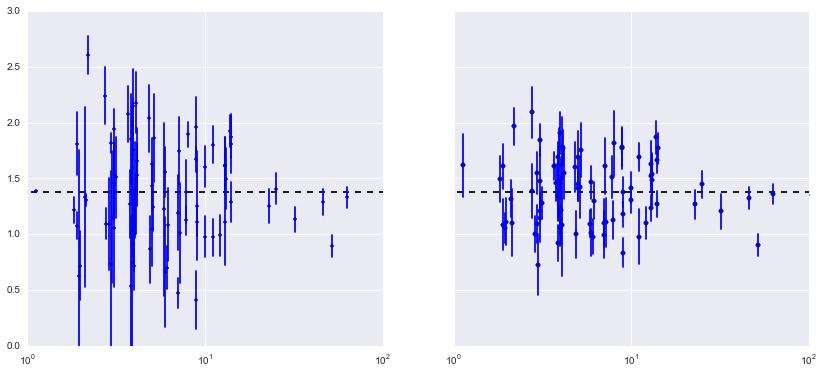

In [20]:
sample_trace = M_partial.a.trace()[-1000:]

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

n_county = srrs_mn.groupby('county')['idnum'].count()
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

        
samples, counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    s.sort()
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [21]:
from pymc import Normal, Model, Gamma, Lambda

def varying_intercept():
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    tau_a = Gamma('tau_a', 1, 0.1, value=1)
    
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, size=len(set(county)))
    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    tau_y = Gamma('tau_y', 1, 0.01, value=1)
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a, b=b: a[county] + b * floor_measure)
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    return locals()

We can fit the above model using MCMC.

In [22]:
M_var_int = MCMC(varying_intercept())
M_var_int.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 15.1 sec

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


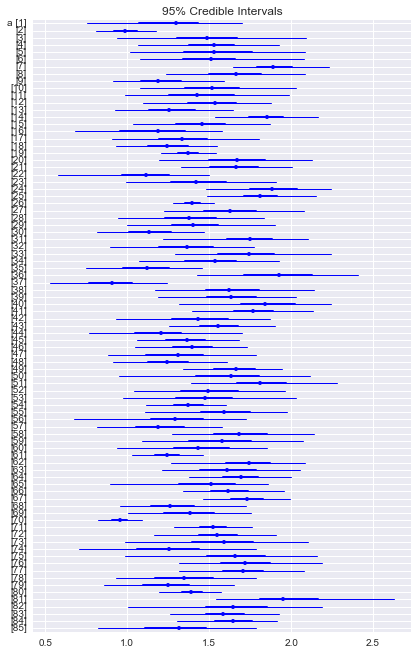

In [23]:
plt.figure(figsize=(6,10))
Matplot.summary_plot(M_var_int.a)

Plotting tau_a
Plotting b


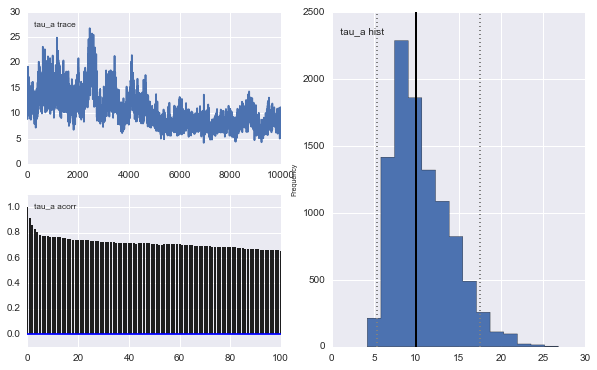

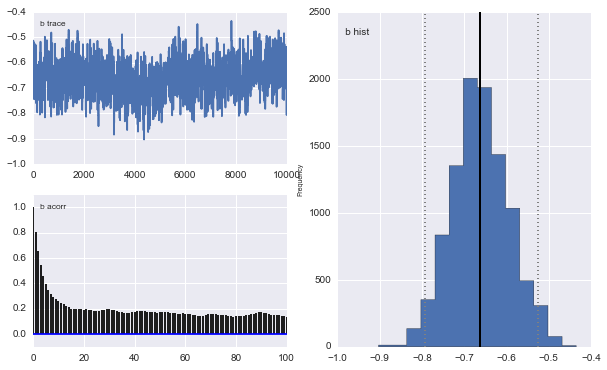

In [24]:
Matplot.plot(M_var_int.tau_a)
Matplot.plot(M_var_int.b)

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [25]:
M_var_int.b.summary()


b:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.661           0.067            0.003            [-0.793 -0.525]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.788           -0.706          -0.663         -0.617        -0.518
	


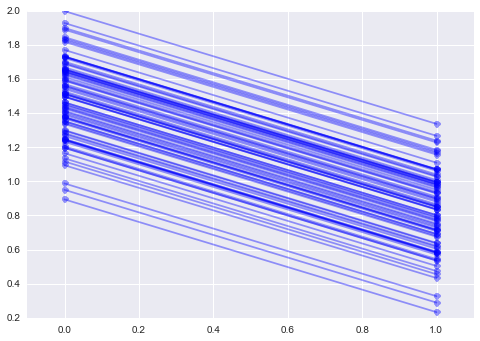

In [26]:
xvals = np.arange(2)
bp = M_var_int.a.trace().mean(axis=0)
mp = M_var_int.b.trace().mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

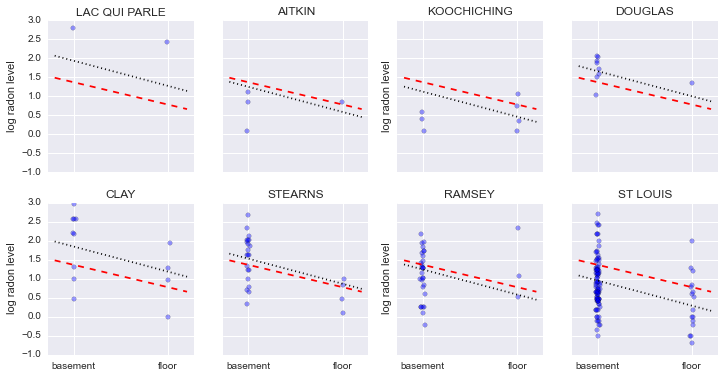

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m,b = unpooled_estimates[['floor', c]]
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [28]:
def varying_slope():
    
    # Priors
    mu_b = Normal('mu_b', mu=0., tau=0.0001, value=0)
    tau_b = Gamma('tau_b', 1, 0.1, value=1)
    
    # Common intercepts
    a = Normal('a', mu=0., tau=0.0001)
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, size=len(set(county)))
    
    # Model error
    tau_y = Gamma('tau_y', 1, 0.01, value=1)
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a, b=b: a + b[county] * floor_measure)
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    return locals()

In [29]:
M_var_slope = MCMC(varying_slope())
M_var_slope.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 16.8 sec

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


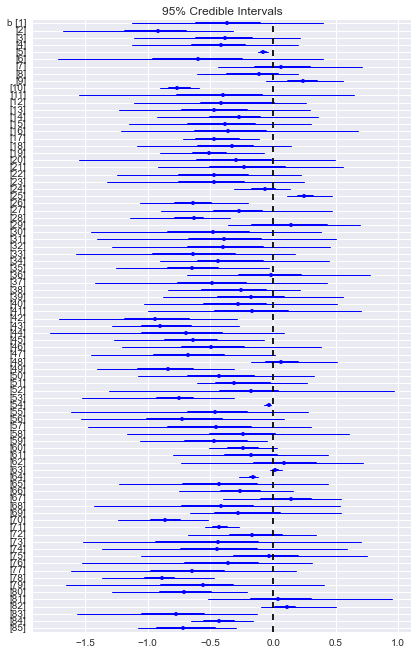

In [30]:
plt.figure(figsize=(6,10))
Matplot.summary_plot(M_var_slope.b)

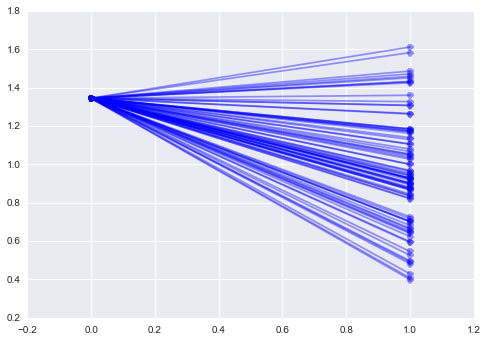

In [31]:
xvals = np.arange(2)
b = M_var_slope.a.trace().mean()
m = M_var_slope.b.trace().mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [32]:
def varying_intercept_slope():
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    tau_a = Gamma('tau_a', 1, 0.1, value=1)
    mu_b = Normal('mu_b', mu=0., tau=0.0001, value=0)
    tau_b = Gamma('tau_b', 1, 0.1, value=1)
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, size=len(set(county)))
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, size=len(set(county)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a, b=b: a[county] + b[county] * floor_measure)
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    return locals()

In [33]:
M_var_int_slope = MCMC(varying_intercept_slope())
M_var_int_slope.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 22.1 sec

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


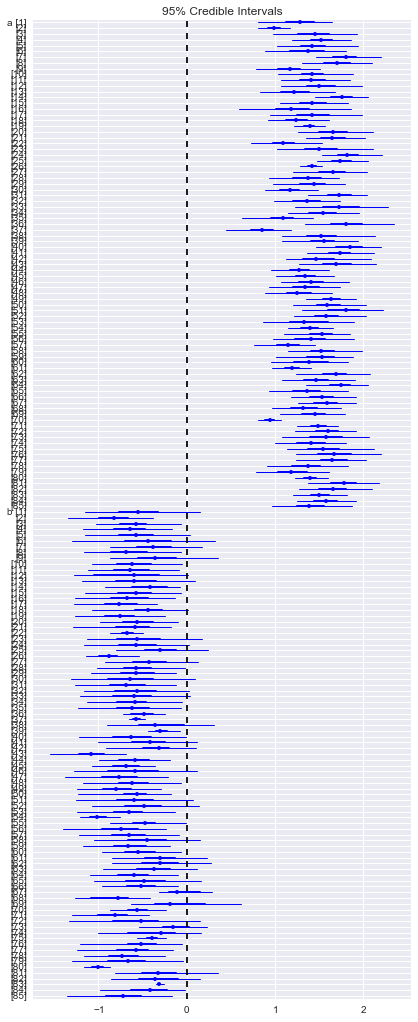

In [34]:
plt.figure(figsize=(6,16))
Matplot.summary_plot([M_var_int_slope.a, M_var_int_slope.b])

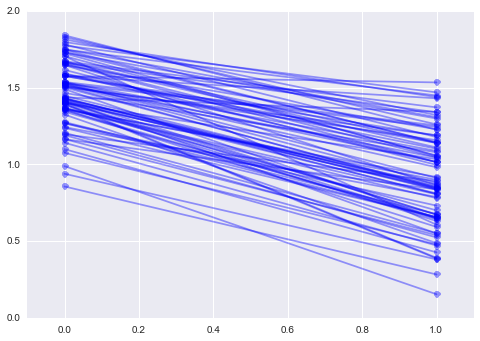

In [35]:
xvals = np.arange(2)
b = M_var_int_slope.a.trace().mean(axis=0)
m = M_var_int_slope.b.trace().mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [36]:
def hierarchical_intercept():
    
    # Priors
    tau_a = Gamma('tau_a', 1, 0.01, value=1)
    
    # County uranium model for slope
    gamma_0 = Normal('gamma_0', mu=0., tau=0.0001, value=0)
    gamma_1 = Normal('gamma_1', mu=0., tau=0.0001, value=0)
    
    
    # Uranium model for intercept
    mu_a = Lambda('mu_a', lambda g0=gamma_0, g1=gamma_1: g0 + g1*u)
    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, tau=tau_a, size=len(set(county)))
    a = Lambda('a', lambda m=mu_a, e=eps_a: m + e[county])
    
    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a, b=b: a + b * floor_measure)
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    return locals()

In [37]:
M_hierarchical = MCMC(hierarchical_intercept())
M_hierarchical.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 92.5 sec

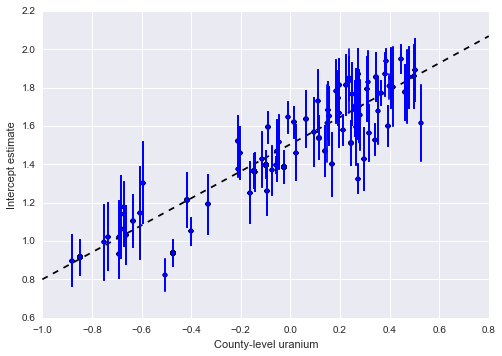

In [38]:
a_means = M_hierarchical.a.trace().mean(axis=0)
plt.scatter(u, a_means)
g0 = M_hierarchical.gamma_0.trace().mean()
g1 = M_hierarchical.gamma_1.trace().mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = M_hierarchical.a.trace().std(axis=0)
for ui, m, se in zip(u, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate')

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [39]:
# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

In [40]:
def contextual_effect():
    
    # Priors
    tau_a = Gamma('tau_a', 1, 0.01, value=1)
    
    # County uranium model for slope
    gamma = Normal('gamma_0', mu=0., tau=0.0001, value=[0]*3)
    
    # Uranium model for intercept
    mu_a = Lambda('mu_a', lambda g=gamma: g[0] + g[1]*u.values + g[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, tau=tau_a, size=len(set(county)))
    a = Lambda('a', lambda m=mu_a, e=eps_a: m + e[county])

    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a, b=b: a + b * floor_measure)
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    return locals()

In [41]:
M_contextual = MCMC(contextual_effect())
M_contextual.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 23.0 sec

Plotting gamma_0_0
Plotting gamma_0_1
Plotting gamma_0_2


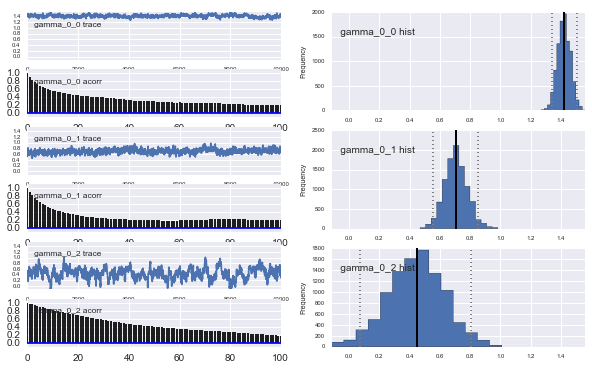

In [42]:
Matplot.plot(M_contextual.gamma)

In [43]:
M_contextual.gamma.summary()


gamma_0:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.419            0.042            0.003            [ 1.339  1.503]
	0.706            0.075            0.004            [ 0.552  0.851]
	0.441            0.186            0.014            [ 0.073  0.807]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.337            1.391           1.419          1.448         1.503
	0.56             0.656           0.703          0.755         0.866
	0.065            0.315           0.447          0.57          0.802
	


So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [44]:
county_lookup['ST LOUIS']

69

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is simply a matter of adding a single additional line in PyMC:

In [45]:
def contextual_pred():
    
    # Priors
    tau_a = Gamma('tau_a', 1, 0.01, value=1)
    
    # County uranium model for slope
    gamma = Normal('gamma_0', mu=0., tau=0.0001, value=[0]*3)
    
    # Uranium model for intercept
    mu_a = Lambda('mu_a', lambda g=gamma: g[0] + g[1]*u.values + g[2]*xbar[county])

    # County variation not explained by uranium
    eps_a = Normal('eps_a', mu=0, tau=tau_a, size=len(set(county)))
    a = Lambda('a', lambda m=mu_a, e=eps_a: m + e[county])

    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = Lambda('y_hat', lambda a=a, b=b: a + b * floor_measure)
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, value=log_radon, observed=True)
    
    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, tau=tau_y)
    
    return locals()

In [46]:
M_pred = MCMC(contextual_pred())
M_pred.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 27.5 sec

In [47]:
M_pred.stl_pred.summary()


stl_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.708            0.737            0.008            [-0.785  2.124]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.724           0.214           0.701          1.203         2.193
	


## Exercise

How would we make a prediction from a new county (*e.g.* one not included in this dataset)?

In [48]:
# Write your answer here

## Benefits of Multilevel Models

Accounting for natural hierarchical structure of observational data

Estimation of coefficients for (under-represented) groups

Incorporating individual- and group-level information when estimating group-level coefficients

Allowing for variation among individual-level coefficients across groups



## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.